In [194]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.lines import Line2D
from scipy.linalg import block_diag

sys.path.append(os.path.abspath(os.path.join('../../src')))
sys.path.append(os.path.abspath(os.path.join('../newton_based_algorithms')))

from utils import get_form_initial_conditions
try:
    from tudatpy.astro.time_conversion import DateTime
    use_tudatpy = True
except ImportError:
    print('No tudatpy available')
    use_tudatpy = False
from dynamics import SatelliteDynamics, Propagator

from unkkt import UNKKT
from tree_newton import Tree_Newton
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

try:
    from concurrent.futures import ProcessPoolExecutor
    use_several_cpus = True
except ImportError:
    print('No concurrent.futures.ProcessPoolExecutor available')
    use_several_cpus = False
use_several_cpus = True

use_causal = True

No tudatpy available


In [195]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [196]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]

# Set simulation start (0 TDB seconds since J2000) and end epochs
if use_tudatpy:
    simulation_start_epoch = DateTime(2000, 1, 1).epoch()
    simulation_end_epoch = (T - 1) * dt

T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # State dimension
n_p = 3  
n_y_1 = 3 
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 5 # Window size [min]

In [197]:
# Initial state vector and get the true state vectors
X_initial = get_form_initial_conditions(formation)
if use_tudatpy:
    propagator = Propagator(simulation_start_epoch, simulation_end_epoch, dt, X_initial)
    X_true = propagator.run().T.reshape(24, 1, T)
else:
    X_true = np.zeros((24, 1, T))
    X_true[:, :, 0] = X_initial
    for t in range(T - 1):
        X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

In [198]:
if use_tudatpy:
    # Estimate process noise
    X_our_model = np.zeros((24, 1, T))
    X_our_model[:, :, 0] = X_initial
    for t in range(T - 1):
        X_our_model[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

    # Compute the difference between the ground truth and the model after initial conditions
    diff = X_true[:, :, 1:] - X_our_model[:, :, 1:]
    diff_flattened = diff.T.reshape(-1, 24)

    # Calculate the general covariance matrix of the flattened differences
    Q = np.cov(diff_flattened, rowvar=False)

    # Create a zero matrix of the same shape
    Q_modified = np.zeros_like(Q)

    # Fill only the required block diagonals
    Q_modified[:6, :6] = np.diag(np.diag(Q[:6, :6]))
    Q_modified[6:12, 6:12] = np.diag(np.diag(Q[6:12, 6:12]))
    Q_modified[12:18, 12:18] = np.diag(np.diag(Q[12:18, 12:18]))
    Q_modified[18:, 18:] = np.diag(np.diag(Q[18:, 18:]))
    Q = Q_modified
    pd.DataFrame(Q[:6, :6]), pd.DataFrame(Q[6:12, 6:12]), pd.DataFrame(Q[12:18, 12:18]), pd.DataFrame(Q[18:, 18:])

In [199]:
# propagator2 = Propagator(simulation_start_epoch, simulation_end_epoch, 1.0, X_initial)
# X_true2 = propagator2.run().T.reshape(24, 1, 23641)

# # Estimate process noise
# X_our_model2 = np.zeros((24, 1, 23641))
# X_our_model2[:, :, 0] = X_initial
# for t in range(23641 - 1):
#     X_our_model2[:, :, t + 1] = SatelliteDynamics().x_new(1.0, X_true2[:, :, t])

# # Compute the difference between the ground truth and the model after initial conditions
# diff2 = X_true2[:, :, 1:] - X_our_model2[:, :, 1:]
# diff_flattened2 = diff2.T.reshape(-1, 24)

# # Calculate the general covariance matrix of the flattened differences
# Q2 = np.cov(diff_flattened2, rowvar=False)

# # Create a zero matrix of the same shape
# Q_modified2 = np.zeros_like(Q2)

# # Fill only the required block diagonals
# Q_modified2[:6, :6] = np.diag(np.diag(Q2[:6, :6]))
# Q_modified2[6:12, 6:12] = np.diag(np.diag(Q2[6:12, 6:12]))
# Q_modified2[12:18, 12:18] = np.diag(np.diag(Q2[12:18, 12:18]))
# Q_modified2[18:, 18:] = np.diag(np.diag(Q2[18:, 18:]))
# Q2 = Q_modified2
# pd.DataFrame(Q2[:6, :6]), pd.DataFrame(Q2[6:12, 6:12]), pd.DataFrame(Q2[12:18, 12:18]), pd.DataFrame(Q2[18:, 18:])

In [200]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [201]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
unkkt.grad_tol = tol
unkkt.max_iter = max_iter

tree_newton = Tree_Newton(W, R_chief, r_deputy_pos)
tree_newton.grad_tol = tol
tree_newton.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
approxh_newton.grad_tol = tol
approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
mm_newton.grad_tol = tol
mm_newton.max_iter = 10
mm_newton.mm_tol = tol
mm_newton.mm_max_iter = 10

In [202]:
# Simulation setup
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial = position_estimation_error(X_est, X_true)

In [203]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False): # n is the index of the end of the finite-horizon window
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n - W + 1 : n + 1])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n - W + 1] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est_unkkt[18:21])} m")
            print("-------- Tree Newton --------")
            X_est_tree_newton = tree_newton.solve_for_each_window(dt, X_est_tree_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(tree_newton.cost_function_values, '.-', label='Tree Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{H}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()

            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(tree_newton.grad_norm_values, '.-', label='Tree Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{H}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()

            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            tree_newton.cost_function_values = []
            tree_newton.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

In [204]:
if use_several_cpus and not use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs AND NONCAUSAL
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = np.zeros((24, 1, K))  # Centralized Newton
    X_est_tree_newton_history = np.zeros((24, 1, K))  # Tree Newton
    X_est_approx_newton_history = np.zeros((24, 1, K))  # ApproxH Newton
    X_est_mm_history = np.zeros((24, 1, K))  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W], X_true[:, :, n])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
    
        for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=4) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Store X_est history per algorithm
            X_est_unkkt_history[:, :, n] = X_est_unkkt
            X_est_tree_newton_history[:, :, n] = X_est_tree_newton
            X_est_approx_newton_history[:, :, n] = X_est_approx_newton
            X_est_mm_history[:, :, n] = X_est_mm
    
            # Plot results **in the main process**
            fig, axs = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8))
    
            # Cost function values
            axs[0].plot(cost_unkkt, '.-', label='Centralized Newton')
            axs[0].plot(cost_tree, '.-', label='Tree Newton (original)')
            axs[0].plot(cost_approx, '.-', label='ApproxH Newton')
            axs[0].plot(cost_mm, '.-', label='MM Newton Cost Function')
            axs[0].plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            axs[0].set_xlabel('Iteration')
            axs[0].set_ylabel(r'$\frac{1}{H}$ Cost Function')
            axs[0].set_yscale('log')
            axs[0].grid(True)
            axs[0].legend()
    
            # Gradient norm values
            axs[1].plot(grad_unkkt, '.-', label='Centralized Newton')
            axs[1].plot(grad_tree, '.-', label='Tree Newton')
            axs[1].plot(grad_approx, '.-', label='ApproxH Newton')
            axs[1].plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            axs[1].plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel(r'$\frac{1}{H}$ Gradient Norm')
            axs[1].set_yscale('log')
            axs[1].grid(True)
            axs[1].legend()

            # Initialize storage for current estimates
            X_est_unkkt_current = np.zeros((24, 1, W))
            X_est_tree_newton_current = np.zeros((24, 1, W))
            X_est_approx_newton_current = np.zeros((24, 1, W))
            X_est_mm_current = np.zeros((24, 1, W))
            
            # Simulate forward propagation over the window
            X_est_unkkt_current[:, :, 0] = X_est_unkkt
            X_est_tree_newton_current[:, :, 0] = X_est_tree_newton
            X_est_approx_newton_current[:, :, 0] = X_est_approx_newton
            X_est_mm_current[:, :, 0] = X_est_mm
            
            for tau in range(W - 1):
                X_est_unkkt_current[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_current[:, :, tau])
                X_est_tree_newton_current[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_current[:, :, tau])
                X_est_approx_newton_current[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_current[:, :, tau])
                X_est_mm_current[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_current[:, :, tau])
            
            # Compute position estimation errors
            dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current = position_estimation_error(X_est_unkkt_current, X_true[:, :, n:n + W])
            dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current = position_estimation_error(X_est_tree_newton_current, X_true[:, :, n:n + W])
            dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current = position_estimation_error(X_est_approx_newton_current, X_true[:, :, n:n + W])
            dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current = position_estimation_error(X_est_mm_current, X_true[:, :, n:n + W])
            
            # Define colors for algorithms
            algorithm_colors = {
                'Initial guess': 'grey',
                'Centralized Newton': 'C0',
                'Tree Newton': 'C1',
                'ApproxH Newton': 'C2',
                'MM Newton': 'C3'
            }
            
            # Define markers for different agents (i = 1, ..., 4)
            markers = ['.', '^', '2', 's', 'P']
            
            # Plot Initial Guess deviations (use the same color for all i)
            for i, dev_initial in enumerate([dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial]):
                axs[2].plot(dev_initial[n:n + W - 1], linestyle='-', color=algorithm_colors['Initial guess'], marker=markers[i])
            
            # Plot Centralized Newton deviations
            for i, dev_unkkt in enumerate([dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current]):
                axs[2].plot(dev_unkkt, linestyle='-', color=algorithm_colors['Centralized Newton'], marker=markers[i])
            
            # Plot Tree Newton deviations
            for i, dev_tree in enumerate([dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current]):
                axs[2].plot(dev_tree, linestyle='-', color=algorithm_colors['Tree Newton'], marker=markers[i])
            
            # Plot ApproxH Newton deviations
            for i, dev_approxh in enumerate([dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current]):
                axs[2].plot(dev_approxh, linestyle='-', color=algorithm_colors['ApproxH Newton'], marker=markers[i])
            
            # Plot MM Newton deviations
            for i, dev_mm in enumerate([dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current]):
                axs[2].plot(dev_mm, linestyle='-', color=algorithm_colors['MM Newton'], marker=markers[i])
            
            # Set axis labels and scale
            axs[2].set_xlabel(r'$\tau$')
            axs[2].set_ylabel(r'$\left\|\hat{\mathbf{p}}_i(\tau) - \mathbf{p}_i(\tau)\right\|$ [m]')
            axs[2].set_yscale('log')
            axs[2].grid(True)
            
            # Create legend (Colors for Algorithms, Markers for Agents)
            legend_elements = [
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Initial guess'], label='Initial guess'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Centralized Newton'], label='Centralized Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Tree Newton'], label='Tree Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['ApproxH Newton'], label='ApproxH Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['MM Newton'], label='MM Newton'),
                Line2D([0], [0], linestyle='', marker='.', color='black', label='$i = 1$'),
                Line2D([0], [0], linestyle='', marker='^', color='black', label='$i = 2$'),
                Line2D([0], [0], linestyle='', marker='2', color='black', label='$i = 3$'),
                Line2D([0], [0], linestyle='', marker='s', color='black', label='$i = 4$')
            ]
            fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
            fig.suptitle(f'Window k = {n}')
            plt.tight_layout() 
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

Windows:   0%|          | 0/6 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- Tree Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 407826.29316489556
Gradient norm: 1040024.8189280652
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
L_norm = 407826.29316489556
Grad_L_norm = 1040024.8189280652

Before applying the algorithm
Cost function: 407826.29316489556
Gradient norm: 1039240.7196921689
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Iteration 1
Cost function: 15668874.601256311 (3742.05%)
Gradient norm: 1614071.9060716822 (55.20%)
Global relative error: 698.0835733709356 (76.46%)
Position relative errors: 2.5138859392811526 m, 103.6719790530027 m, 341.8855649753408 m, 599.1544704532415 m

Iteration 1
L_norm = 381788.08652367134
Grad_

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.13689e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 18
Cost function: 573841395.845632 (-71.39%)
Gradient norm: 4065856.0649995557 (-49.50%)
Global relative error: 46509.70803970406 (-34.72%)
Position relative errors: 503.6694720425894 m, 17429.952444297287 m, 17629.160946929755 m, 39347.39957115873 m

Iteration 19
L_norm = 329.90978843153755
Grad_L_norm = 6154.38666883651

Iteration 19
Cost function: 45558543181.75863 (16313645.10%)
Gradient norm: 31642558.719325166 (95445.60%)
Global relative error: 141096.48721450294 (16160.41%)
Position relative errors: 0.1897382907875836 m, 391.9988672223995 m, 386.8185310366013 m, 141095.09102107928 m

Iteration 19
Cost function: 2004844494.80306 (249.37%)
Gradient norm: 15638572.71918311 (284.63%)
Global relative error: 37904.1052115459 (-18.50%)
Position relative errors: 511.061931816015 m, 26373.950375510398 m, 23773.13883892995 m, 13249.568088280495 m

Iteration 20
L_norm = 2.394394653071095
Grad_L_norm = 14.701839779341432

Iteration 20
Cost function: 2655710.2065761583 (-99.99%)
Gr

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.18769e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 60
Cost function: 5887986.890170287 (-42.21%)
Gradient norm: 819496.9067807815 (36.02%)
Global relative error: 5457.027428872279 (14.18%)Iteration 62
L_norm = 1157099587.1659064
Grad_L_norm = 12427750.611227794


Position relative errors: 11.75587148890177 m, 4152.156650959421 m, 2448.1951116371897 m, 2558.113715885771 m

Iteration 63
Cost function: 1702454.848144892 (-0.60%)
Gradient norm: 0.07469048323858096 (-99.99%)
Global relative error: 2655.081278593286 (-0.05%)
Position relative errors: 0.18973830016329232 m, 638.1362092860618 m, 1757.814587533891 m, 1884.7517062247287 m

Iteration 63
L_norm = 150063.41216403054
Grad_L_norm = 56216.18772216346
Iteration 61
Cost function: 810321.0873170901 (-86.24%)
Gradient norm: 224355.89656645065 (-72.62%)
Global relative error: 4671.224015123438 (-14.40%)

Position relative errors: 16.768062596563862 m, 2426.657020996232 m, 2924.540735262618 m, 2716.2100171046727 m

Iteration 64
Cost function: 1950446.1267997944 (14.57%)
Gradient n

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=8.1136e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 64
L_norm = 879626969.6785094
Grad_L_norm = 10963955.358813683

Iteration 62
Cost function: 775434.496096323 (-4.31%)
Gradient norm: 210030.00514464854 (-6.39%)
Global relative error: 3319.687420810397 (-28.93%)
Position relative errors: 2.3470867502180113 m, 2271.7275197974045 m, 1780.7772742824234 m, 1639.5156634389111 m

Iteration 65
Cost function: 1925489.3437507101 (-1.28%)
Gradient norm: 8.25184906955262 (-99.73%)
Global relative error: 2753.8059428697243 (-0.54%)
Position relative errors: 0.18973830037374645 m, 639.6343733056511 m, 1903.1521769131 m, 1884.751733420303 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.63567e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 65
L_norm = 201108.25673646346
Grad_L_norm = 77393.60792610396

Iteration 63
Cost function: 75578.67912489569 (-90.25%)
Gradient norm: 40463.58871005785 (-80.73%)
Global relative error: 3215.849861473095 (-3.13%)
Position relative errors: 1.1835944978780735 m, 1821.5647134282578 m, 1978.4131479307684 m, 1763.274317005305 m

Iteration 66
Cost function: 1927106.6668595162 (0.08%)
Gradient norm: 0.22523926888912651 (-97.27%)
Global relative error: 2754.425614955558 (0.02%)
Position relative errors: 0.1897383000317676 m, 639.6373638744441 m, 1904.0477099631378 m, 1884.7517340180395 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.69458e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 66
L_norm = 689514.2523001876
Grad_L_norm = 244667.91621625674

Iteration 64
Cost function: 14004753.276055336 (18430.03%)
Gradient norm: 620202.4145816901 (1432.74%)
Global relative error: 7689.083165531086 (139.10%)
Position relative errors: 11.505046207123344 m, 1887.2055521526331 m, 2590.6400426424493 m, 6989.106522559643 m

Iteration 67
Cost function: 1965003.5801567812 (1.97%)
Gradient norm: 130.64205208626353 (57901.45%)
Global relative error: 2760.2021189769926 (0.21%)
Position relative errors: 0.1897383000388142 m, 639.6373704492693 m, 1912.3943816698832 m, 1884.7517248349454 m

Iteration 67
L_norm = 642746.8559135806
Grad_L_norm = 213270.55757277552


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.26513e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 65
Cost function: 3226012.1540880417 (-76.96%)
Gradient norm: 236040.02024878268 (-61.94%)
Global relative error: 6725.618844513495 (-12.53%)
Position relative errors: 13.631395875625971 m, 4660.2438943641055 m, 4247.2552786265705 m, 2340.1011243415414 m

Iteration 68
Cost function: 1964519.2348742099 (-0.02%)
Gradient norm: 0.008204378729480028 (-99.99%)
Global relative error: 2760.14209661182 (-0.00%)
Position relative errors: 0.1897383000271788 m, 639.6373780428646 m, 1912.3077476659614 m, 1884.751723832403 m

Iteration 68
L_norm = 362474.4122104528
Grad_L_norm = 34020.91506291628


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.28308e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 66
Cost function: 5770383.326838356 (78.87%)
Gradient norm: 916239.0463089014 (288.17%)
Global relative error: 5248.202170444139 (-21.97%)
Position relative errors: 21.52602222532601 m, 3220.029073494039 m, 2665.8185197868083 m, 3172.924225623389 m

Iteration 69
Cost function: 3622738.7151535666 (84.41%)
Gradient norm: 85540.67707287542 (1042622137.39%)
Global relative error: 3302.0029248053816 (19.63%)
Position relative errors: 0.18973829969419553 m, 639.6373780471827 m, 2634.7189890615573 m, 1884.7526514834656 m

Iteration 69
L_norm = 342950.29571829335
Grad_L_norm = 18822.126718920004


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.88126e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 67
Cost function: 1352765.7876791372 (-76.56%)
Gradient norm: 358220.64793166093 (-60.90%)
Global relative error: 4694.079467899138 (-10.56%)
Position relative errors: 13.62877921538595 m, 2637.3901765268665 m, 2785.3926080299884 m, 2705.4927291983627 m

Iteration 70
Cost function: 2561707.8575817514 (-29.29%)
Gradient norm: 694.38282238614 (-99.19%)
Global relative error: 2985.0143181868416 (-9.60%)
Position relative errors: 0.1897383516897828 m, 639.6373788256952 m, 2224.5970846762953 m, 1884.7528772702497 m
Iteration 70
L_norm = 19358422.64248724
Grad_L_norm = 1121599.1419476082




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.14089e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 68
Cost function: 2647864494.0694323 (195637.10%)
Gradient norm: 4210660.4457081575 (1075.44%)
Global relative error: 72526.6787420129 (1445.07%)
Position relative errors: 226.82591365340662 m, 72451.87405114625 m, 2230.9801324288514 m, 2381.5453324463715 m

Iteration 71
Cost function: 2609878.4185617017 (1.88%)
Gradient norm: 496.3637489388861 (-28.52%)
Global relative error: 2960.422029478373 (-0.82%)
Position relative errors: 0.18973826955584394 m, 639.6373778271121 m, 2191.487948078835 m, 1884.75298906827 m
Iteration 71
L_norm = 598692.4975019452
Grad_L_norm = 65805.71825333174




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.78566e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 69
Cost function: 1263788209.8247006 (-52.27%)
Gradient norm: 5046996.471603684 (19.86%)
Global relative error: 59472.43154401929 (-18.00%)
Position relative errors: 222.66921382348542 m, 2154.2001927689253 m, 40802.099354764025 m, 43212.37736005097 m

Iteration 72
Cost function: 2581457.5085234484 (-1.09%)
Gradient norm: 248.75693912781006 (-49.88%)
Global relative error: 2941.566894974619 (-0.64%)Iteration 72
L_norm = 17973472.135189313
Grad_L_norm = 1529622.2416754302


Position relative errors: 0.18973830263984692 m, 639.6373780371899 m, 2165.9490631602634 m, 1884.7530476801883 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.03082e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 70
Cost function: 339367814.0116429 (-73.15%)
Gradient norm: 1599909.8019049559 (-68.30%)
Global relative error: 38662.250473602566 (-34.99%)
Position relative errors: 453.2781007091401 m, 32053.487640185136 m, 15557.47669223744 m, 15001.216321671405 m

Iteration 73
Cost function: 2579827.4380068006 (-0.06%)
Gradient norm: 1.9043645759355976 (-99.23%)
Global relative error: 2944.6157196797512 (0.10%)Iteration 73
L_norm = 370892.36635161145
Grad_L_norm = 61393.89578800531


Position relative errors: 0.18973830105303172 m, 639.6373780498263 m, 2170.0878990947294 m, 1884.7530638909975 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.41552e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 71
Cost function: 104615256.56262964 (-69.17%)
Gradient norm: 751422.9824266535 (-53.03%)
Global relative error: 25656.40981511468 (-33.64%)
Position relative errors: 376.76824734806564 m, 11277.45943112561 m, 16224.369646405517 m, 16360.589993720854 m

Iteration 74
L_norm = 1203977.6908314354
Grad_L_norm = 121169.5262188387
Iteration 74
Cost function: 2582024.531372886 (0.09%)
Gradient norm: 593.6410022325417 (31072.66%)
Global relative error: 2969.1608159033417 (0.83%)

Position relative errors: 0.18973830015404722 m, 639.6373780267268 m, 2203.2787566528796 m, 1884.7530456315678 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.39139e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 72
Cost function: 493040528.83906716 (371.29%)
Gradient norm: 5389105.338862448 (617.19%)
Global relative error: 34573.746576362675 (34.76%)
Position relative errors: 476.03700594226507 m, 10599.677684099448 m, 24613.53331139427 m, 21837.24849930548 m

Iteration 75
L_norm = 340933.72149822215
Grad_L_norm = 23960.956772298305

Iteration 75
Cost function: 2576438.5031974637 (-0.22%)
Gradient norm: 0.20622288175706563 (-99.97%)
Global relative error: 2967.651390238961 (-0.05%)
Position relative errors: 0.18973830008934336 m, 639.6373780438055 m, 2201.244225110548 m, 1884.75304982107 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.69801e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 73
Cost function: 128125894.2833662 (-74.01%)
Gradient norm: 1931832.7922363696 (-64.15%)
Global relative error: 22365.094627900646 (-35.31%)
Position relative errors: 315.18050888270284 m, 15862.519176671183 m, 10760.573632301068 m, 11517.650266372802 m

Iteration 76
L_norm = 301438.8553309606
Grad_L_norm = 28394.62136398967

Iteration 76
Cost function: 2613841.1860094876 (1.45%)
Gradient norm: 1104.9985204814009 (535727.31%)
Global relative error: 3005.6590781921186 (1.28%)
Position relative errors: 0.18973829933435726 m, 639.6373780448245 m, 2252.223168467524 m, 1884.7530265845612 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.91791e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 74
Cost function: 135515872.94668928 (5.77%)
Gradient norm: 2768664.176894793 (43.32%)
Global relative error: 17256.996349948135 (-22.84%)
Position relative errors: 237.49576226113405 m, 7962.739952504199 m, 10796.512523068199 m, 10851.237661701336 m

Iteration 77
L_norm = 280795.6482577371
Grad_L_norm = 20248.06444822406

Iteration 77
Cost function: 2601394.1403014953 (-0.48%)
Gradient norm: 0.6053984402086249 (-99.95%)
Global relative error: 3000.469995021867 (-0.17%)
Position relative errors: 0.18973829927526797 m, 639.6373780460839 m, 2245.2934808667537 m, 1884.753048008065 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.90586e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 75
Cost function: 36890680.93411064 (-72.78%)
Gradient norm: 1077439.0313606884 (-61.08%)
Global relative error: 11674.009152050747 (-32.35%)
Position relative errors: 151.92434972564277 m, 7440.310360685457 m, 6300.278373988397 m, 6418.472909716269 m

Iteration 78
L_norm = 299151.28888811084
Grad_L_norm = 32643.263620940386

Iteration 78
Cost function: 2604212.274930742 (0.11%)
Gradient norm: 0.6736597969499141 (11.28%)
Global relative error: 3000.888442392806 (0.01%)
Position relative errors: 0.1897382992773384 m, 639.6373780448195 m, 2245.852659603666 m, 1884.7530469509952 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.16519e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 76
Cost function: 61987698.76655495 (68.03%)
Gradient norm: 2170959.6634350726 (101.49%)
Global relative error: 7508.896676337738 (-35.68%)
Position relative errors: 85.38841382137522 m, 4696.484308510849 m, 4215.6494294049235 m, 4066.87988025427 m

Iteration 79
L_norm = 275300.51878247695
Grad_L_norm = 39979.08990900843

Iteration 79
Cost function: 2601861.5151879997 (-0.09%)
Gradient norm: 7.589916441266111 (1026.67%)
Global relative error: 3000.3974937183066 (-0.02%)
Position relative errors: 0.18973829928373528 m, 639.6373780356923 m, 2245.1965195024595 m, 1884.7530478266176 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.09678e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 77
Cost function: 19590691.232088316 (-68.40%)
Gradient norm: 861714.1542208766 (-60.31%)
Global relative error: 5584.432145432036 (-25.63%)
Position relative errors: 53.64744268257002 m, 3247.6692005122786 m, 3142.4110499661892 m, 3279.795266666811 m

Iteration 80
L_norm = 309561.7045199042
Grad_L_norm = 58237.78396633322

Iteration 80
Cost function: 2600619.699642609 (-0.05%)
Gradient norm: 0.06472897013767367 (-99.15%)
Global relative error: 3000.037870448579 (-0.01%)
Position relative errors: 0.18973829925661836 m, 639.6373780354745 m, 2244.7158881225237 m, 1884.7530487128915 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.68445e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 78
Cost function: 12463012.545739533 (-36.38%)
Gradient norm: 1357819.451048515 (57.57%)
Global relative error: 4743.823501950775 (-15.05%)
Position relative errors: 35.925751861489495 m, 2527.41779787681 m, 3105.015978890509 m, 2544.205217313241 m

Iteration 81
L_norm = 338925.7911972754
Grad_L_norm = 59750.540544018004

Iteration 81
Cost function: 2596244.3877183306 (-0.17%)
Gradient norm: 124.70003857720899 (192549.50%)
Global relative error: 2999.4461582559175 (-0.02%)
Position relative errors: 0.18973829924644706 m, 639.637378046444 m, 2243.924663596188 m, 1884.7530471112798 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.09898e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 79
Cost function: 1585517.121814362 (-87.28%)
Gradient norm: 350955.57145093713 (-74.15%)
Global relative error: 4009.182318718165 (-15.49%)
Position relative errors: 24.741021915527586 m, 2305.2986492819737 m, 2196.925962553308 m, 2435.544272054875 m

Iteration 82
L_norm = 298140.4254221596
Grad_L_norm = 13378.558029675842

Iteration 82
Cost function: 2595645.952723437 (-0.02%)
Gradient norm: 0.0017860426902993642 (-100.00%)
Global relative error: 2999.587133326862 (0.00%)
Position relative errors: 0.18973829926488092 m, 639.6373780353557 m, 2244.1131080748637 m, 1884.7530464461684 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.6642e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 80
Cost function: 2138690.4392165365 (34.89%)
Gradient norm: 349331.02172022214 (-0.46%)
Global relative error: 3885.1787813832507 (-3.09%)
Position relative errors: 12.684267877752951 m, 2027.0586309996067 m, 2267.586251750021 m, 2417.2607541983916 m

Iteration 83
L_norm = 289436.5735065353
Grad_L_norm = 30424.03043789395

Iteration 83
Cost function: 2685826.712826588 (3.47%)
Gradient norm: 3599.595626631031 (201540190.51%)
Global relative error: 3024.579097566486 (0.83%)
Position relative errors: 0.18973829921031327 m, 639.6373780357198 m, 2277.4100206313174 m, 1884.7530456435748 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.87551e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 81
Cost function: 467353.70754898957 (-78.15%)
Gradient norm: 151501.03532998316 (-56.63%)
Global relative error: 3381.461856723321 (-12.97%)
Position relative errors: 6.439817935465481 m, 1863.1044203262982 m, 1859.139967586972 m, 2122.8326439428397 m

Iteration 84
L_norm = 308584.0340901598
Grad_L_norm = 43846.90536850043

Iteration 84
Cost function: 2649405.307457787 (-1.36%)
Gradient norm: 7.720101243392132 (-99.79%)
Global relative error: 3011.951992500873 (-0.42%)
Position relative errors: 0.18973829914768336 m, 639.6373780466531 m, 2260.6130496678334 m, 1884.7533950611955 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.27314e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 82
Cost function: 1931804.0113060134 (313.35%)
Gradient norm: 522696.80096652417 (245.01%)
Global relative error: 3023.2217528297974 (-10.59%)
Position relative errors: 3.1786469498690764 m, 1796.8185318947526 m, 1908.6874424266375 m, 1505.9915751212502 m

Iteration 85
L_norm = 287481.0100952302
Grad_L_norm = 12878.758125307591

Iteration 85
Cost function: 2648536.6419553915 (-0.03%)
Gradient norm: 1.1941585383147717 (-84.53%)
Global relative error: 3012.7551131416203 (0.03%)
Position relative errors: 0.1897382991620032 m, 639.6373780417081 m, 2261.6830099763974 m, 1884.7533908214004 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.48747e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 83
Cost function: 11322560717.000378 (586013.32%)
Gradient norm: 44018071.90400478 (8321.34%)
Global relative error: 9471.923135384677 (213.31%)
Position relative errors: 29.13475738466981 m, 9121.678235595691 m, 1659.7092927107365 m, 1822.9897434072798 m

Iteration 86
L_norm = 349249.62177792465
Grad_L_norm = 77933.68685890423

Iteration 86
Cost function: 2649441.406546307 (0.03%)
Gradient norm: 0.11402185603218144 (-90.45%)
Global relative error: 3013.095114963541 (0.01%)
Position relative errors: 0.18973829916032608 m, 639.6373780374552 m, 2262.1359241153414 m, 1884.7533910491327 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.61963e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 84
Cost function: 12596035544.75661 (11.25%)
Gradient norm: 44141357.138432376 (0.28%)
Global relative error: 11175.735284960816 (17.99%)
Position relative errors: 87.82164614814207 m, 1292.1484761846962 m, 5411.649479610264 m, 9664.772403041883 m

Iteration 87
L_norm = 294206.4812380714
Grad_L_norm = 13229.583078748801

Iteration 87
Cost function: 2650209.7000952926 (0.03%)
Gradient norm: 0.4353881748244588 (281.85%)
Global relative error: 3013.240134706918 (0.00%)
Position relative errors: 0.18973829915540555 m, 639.6373780369222 m, 2262.3290804994344 m, 1884.7533907168622 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.69921e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 85
Cost function: 3691546329.9529433 (-70.69%)
Gradient norm: 19214747.006445456 (-56.47%)
Global relative error: 15239.799073857323 (36.37%)
Position relative errors: 110.5260172530697 m, 14325.030111342134 m, 4246.642955621531 m, 2968.4899796451045 m

Iteration 88
L_norm = 296095.31549828284
Grad_L_norm = 64729.23889613871

Iteration 88
Cost function: 2651153.168178768 (0.04%)
Gradient norm: 0.0745869683318458 (-82.87%)
Global relative error: 3013.345015175704 (0.00%)
Position relative errors: 0.18973829915198365 m, 639.6373780404248 m, 2262.468782331861 m, 1884.753391140889 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.17438e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 86
Cost function: 1075393119.1163905 (-70.87%)
Gradient norm: 7723427.243927568 (-59.80%)
Global relative error: 10125.73371102383 (-33.56%)
Position relative errors: 94.45907120395067 m, 3274.8391701157752 m, 6627.3115969485 m, 6913.638545542521 m

Iteration 89
L_norm = 295964.51455147704
Grad_L_norm = 26937.87260293213

Iteration 89
Cost function: 2651970.5634083645 (0.03%)
Gradient norm: 1.3793360290055459 (1749.30%)
Global relative error: 3013.4490662877015 (0.00%)
Position relative errors: 0.18973829915032728 m, 639.6373780426225 m, 2262.6073467033484 m, 1884.7533912292613 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.25287e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 87
Cost function: 433673242.1597601 (-59.67%)
Gradient norm: 4264770.52580922 (-44.78%)
Global relative error: 7917.917123060072 (-21.80%)
Position relative errors: 63.7984739068633 m, 5306.243669211077 m, 4138.071006257717 m, 4168.32465607981 m

Iteration 90
L_norm = 300484.43257041526
Grad_L_norm = 119310.94139228015

Iteration 90
Cost function: 2652576.9758565514 (0.02%)
Gradient norm: 0.021148404993737942 (-98.47%)
Global relative error: 3013.5102613611525 (0.00%)
Position relative errors: 0.18973829914648827 m, 639.6373780418578 m, 2262.688857967282 m, 1884.7533911034343 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.27934e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 88
Cost function: 192829508.0063941 (-55.54%)
Gradient norm: 2814506.3887490667 (-34.01%)
Global relative error: 6761.495963274398 (-14.61%)
Position relative errors: 45.56853813914539 m, 3654.603991202356 m, 3992.2034251396876 m, 4050.4775398625698 m

Iteration 91
L_norm = 400612.14179706865
Grad_L_norm = 125039.34933020112

Iteration 91
Cost function: 2654918.300737779 (0.09%)
Gradient norm: 7.9526053491117015 (37503.81%)
Global relative error: 3013.790405096354 (0.01%)
Position relative errors: 0.1897382991491965 m, 639.637378033797 m, 2263.0619108279598 m, 1884.753391065712 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.45151e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 89
Cost function: 196668504.66851395 (1.99%)
Gradient norm: 5122008.308189643 (81.99%)
Global relative error: 6591.647039752944 (-2.51%)
Position relative errors: 33.375355330165796 m, 3765.3955865949324 m, 3566.1788395428744 m, 4067.5762069347925 m

Iteration 92
L_norm = 296478.8988296111
Grad_L_norm = 24644.66508809334

Iteration 92
Cost function: 2654953.2088923953 (0.00%)
Gradient norm: 0.0006039423347240129 (-99.99%)
Global relative error: 3013.7804932954487 (-0.00%)
Position relative errors: 0.18973829914074355 m, 639.6373780379845 m, 2263.0487128793843 m, 1884.7533910892014 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.15172e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 90
Cost function: 31636906.323334396 (-83.91%)
Gradient norm: 1372128.184075269 (-73.21%)
Global relative error: 5456.772574355957 (-17.22%)
Position relative errors: 20.44643601085027 m, 3142.3940134533464 m, 3166.278131494115 m, 3142.2190143947846 m

Iteration 93
L_norm = 52514722.98313776
Grad_L_norm = 395320.9371914113

Iteration 93
Cost function: 2684079.862612731 (1.10%)
Gradient norm: 415.684589269319 (68828423.08%)
Global relative error: 3017.1549583786486 (0.11%)
Position relative errors: 0.18973829912975632 m, 639.6373780324043 m, 2267.540533420883 m, 1884.7533897946123 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.06077e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 91
Cost function: 11449359.77177926 (-63.81%)
Gradient norm: 684359.6897075169 (-50.12%)
Global relative error: 4428.052850413574 (-18.85%)
Position relative errors: 6.6641258684781 m, 2423.2892830116903 m, 2420.90889676892 m, 2805.9646074484144 m

Iteration 94
L_norm = 402451.28883862996
Grad_L_norm = 91464.4501380639

Iteration 94
Cost function: 2679186.356729474 (-0.18%)
Gradient norm: 0.14436241798585175 (-99.97%)
Global relative error: 3015.2581594459493 (-0.06%)
Position relative errors: 0.1897382991036988 m, 639.6373780349243 m, 2265.01609359601 m, 1884.7533623341242 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.05532e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 92
Cost function: 821286915.0617841 (7073.21%)
Gradient norm: 11265993.962978145 (1546.21%)
Global relative error: 12109.420899157287 (173.47%)
Position relative errors: 11.683638812140925 m, 5168.707483389141 m, 7147.635628302103 m, 8295.437949781595 m

Iteration 95
L_norm = 324098.4570257146
Grad_L_norm = 162757.87147084746

Iteration 95
Cost function: 2679212.984323592 (0.00%)
Gradient norm: 0.1708883874310375 (18.37%)
Global relative error: 3015.357119686644 (0.00%)
Position relative errors: 0.18973829910586995 m, 639.637378026536 m, 2265.1478241274513 m, 1884.7533624250634 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.00327e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 93
Cost function: 87502216.715345 (-89.35%)
Gradient norm: 3425840.490055172 (-69.59%)
Global relative error: 5442.731441754176 (-55.05%)
Position relative errors: 22.22357444563963 m, 3432.6272755072923 m, 1978.5417464422073 m, 3731.107215566157 m

Iteration 96
L_norm = 38524.06020380034
Grad_L_norm = 10424.572767968975

Iteration 96
Cost function: 2680423.7033580793 (0.05%)
Gradient norm: 0.11270333828266069 (-34.05%)
Global relative error: 3015.3891073421214 (0.00%)
Position relative errors: 0.1897382990995835 m, 639.6373780338693 m, 2265.1904219241565 m, 1884.7533616816463 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.20274e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 94
Cost function: 47456040.1127092 (-45.77%)
Gradient norm: 2668328.9602087294 (-22.11%)
Global relative error: 5644.64262969114 (3.71%)
Position relative errors: 22.412657914316053 m, 3427.118478296133 m, 3328.703039482303 m, 3005.5798905983843 m

Iteration 97
L_norm = 74683.0472857414
Grad_L_norm = 66885.92966884452

Iteration 97
Cost function: 2680468.2013183786 (0.00%)
Gradient norm: 0.070307843282173 (-37.62%)
Global relative error: 3015.387141248668 (-0.00%)
Position relative errors: 0.18973829910006945 m, 639.6373780335412 m, 2265.187797910386 m, 1884.7533618861705 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.53931e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 95
Cost function: 7277489.458410705 (-84.66%)
Gradient norm: 962879.3253617069 (-63.91%)
Global relative error: 5139.008517791775 (-8.96%)
Position relative errors: 18.506123510083786 m, 3014.7154601749944 m, 2804.4002582517496 m, 3074.954060006913 m

Iteration 98
L_norm = 8482.64470014063
Grad_L_norm = 6203.341250672589

Iteration 98
Cost function: 2681661.037268121 (0.04%)
Gradient norm: 0.3869158733405369 (450.32%)
Global relative error: 3015.4153741210766 (0.00%)
Position relative errors: 0.1897382990978981 m, 639.6373780346297 m, 2265.2253839827063 m, 1884.7533639547066 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.19019e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 96
Cost function: 1117307.1423677832 (-84.65%)
Gradient norm: 275171.3447806331 (-71.42%)
Global relative error: 4442.706601414008 (-13.55%)
Position relative errors: 10.9350022199917 m, 2547.595981782798 m, 2606.946527340768 m, 2539.8496946453015 m

STOP on Iteration 99
L_norm = 249625.26738124125
Grad_L_norm = 80551.82887620492

Final position relative errors: [0.18973926233267197, 1904.2746328609912, 1924.038497720137, 1820.7445334764252] m
-------- MM Newton --------

Majorization-Minimization Iteration 1
STOP on Iteration 99
Cost function = 2681653.9286386385 (-0.00%)
Gradient norm = 0.010114316243412651 (-97.39%)
Global relative error = 3015.411524296336 (-0.00%)
Final position relative errors: 0.1897382990975721 m, 639.637378030693 m, 2265.2202563420387 m, 1884.7533639666024 m

Iteration 97
Cost function: 397410.5678316176 (-64.43%)
Gradient norm: 115380.6193623408 (-58.07%)
Global relative error: 4155.895916007306 (-6.46%)
Position relative errors: 5.286569185389841 m

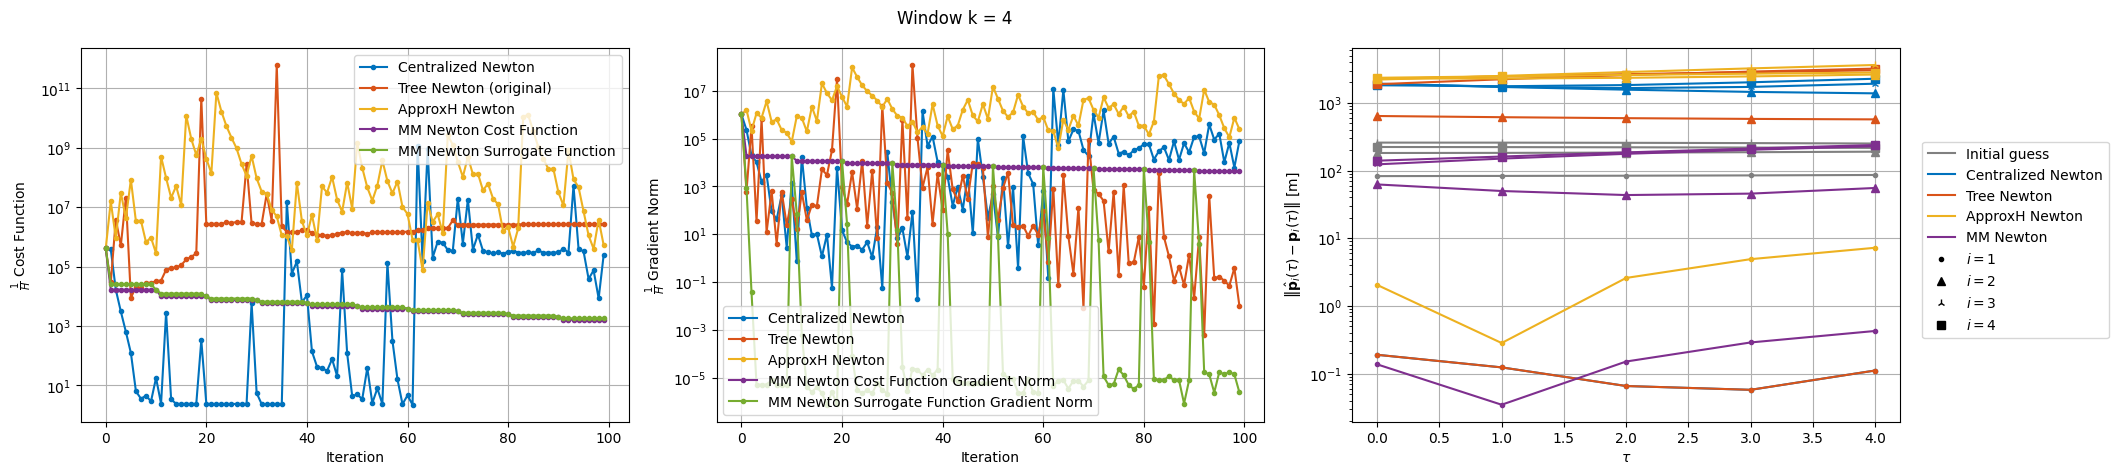


Windows:  17%|█▋        | 1/6 [00:20<01:44, 20.92s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 1877264.3987120003
Gradient norm: 1914.7873724248186
Global relative error: 3378.80985421305
Position relative errors: 0.12356429367714943 m, 614.240216267312 m, 2461.018793230606 m, 2232.129424750895 m

Before applying the algorithm
Cost function: 1011049.2682692313
Gradient norm: 343279.5179983227
Global relative error: 4193.262339561958
Position relative errors: 0.28297209791765393 m, 2287.6175047889074 m, 2502.9269397930593 m, 2466.877454922358 m

Before applying the algorithm
L_norm = 117526.70672186927
Grad_L_norm = 70518.23484446704

Iteration 1
Cost function: 7133562.609950426 (605.56%)
Gradient norm: 941198.2818323397 (174.18%)
Global relative error: 4758.958145510614 (13.49%)
Position relative errors: 6.5888658343916795 m, 3028.0385549508637 m, 2651.1150989496705 m, 2539.571252806888 m

Iteration 1
Cost function: 4430162.371268626 (1

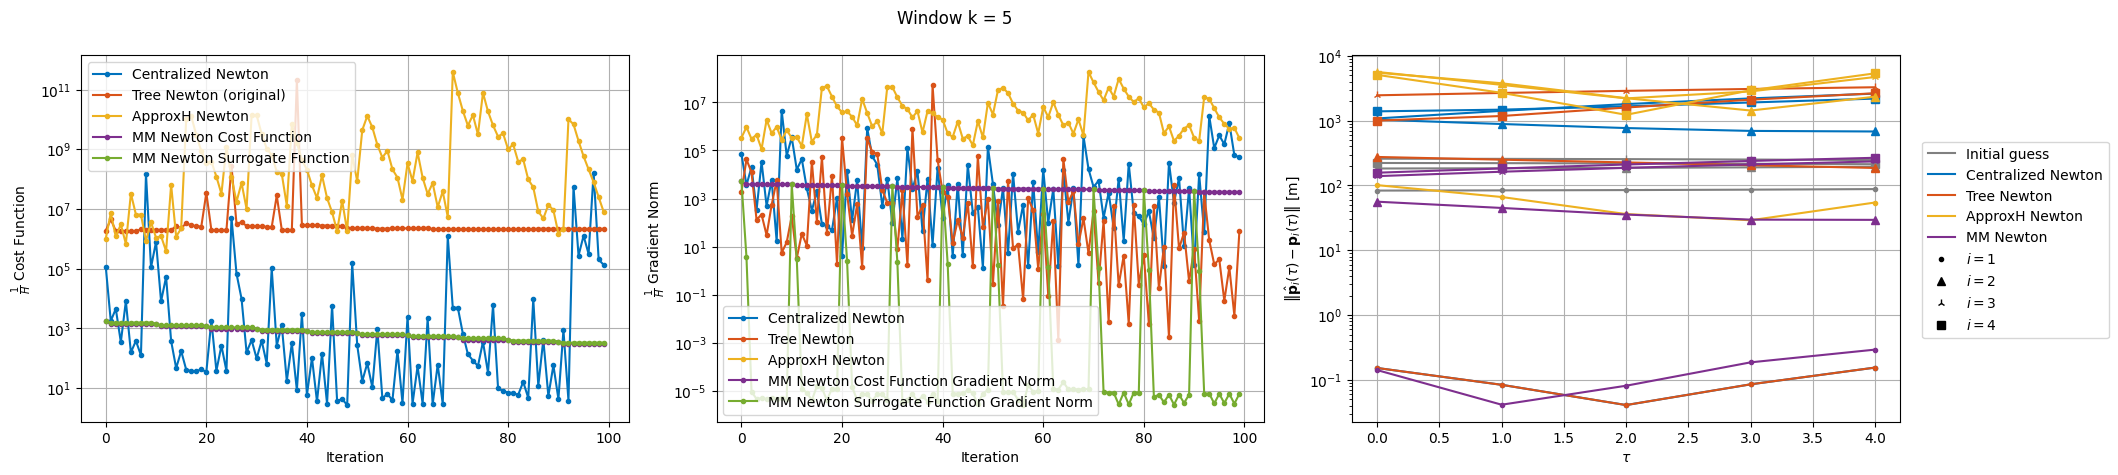


Windows:  33%|███▎      | 2/6 [00:41<01:22, 20.65s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 1473944.7846552448
Gradient norm: 731.2181456049682
Global relative error: 2929.552117245542
Position relative errors: 0.084006000218617 m, 249.63307433800577 m, 2670.6556638528004 m, 1177.8938009668761 m

Before applying the algorithm
Cost function: 7319954.940593828
Gradient norm: 531124.1278030839
Global relative error: 5839.921317795692
Position relative errors: 66.30931001754942 m, 3768.0992554328495 m, 3563.6391469736977 m, 2682.901220729617 m

Before applying the algorithm
L_norm = 90887.60359845565
Grad_L_norm = 58654.807828408295

Iteration 1
Cost function: 1453795.7889892436 (-1.37%)
Gradient norm: 5.085127800390093 (-99.30%)
Global relative error: 2929.831778100527 (0.01%)
Position relative errors: 0.06634622026535673 m, 260.3104027513613 m, 2664.690449062343 m, 1189.7285973336027 m

Iteration 1
Cost function: 35110332.41687314 (379

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.9574e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 35
L_norm = 34120.958513243735
Grad_L_norm = 194.21958057088628

Iteration 35
Cost function: 760539.7490572587 (-61.20%)
Gradient norm: 105198.73891471751 (-61.07%)
Global relative error: 3897.0523307872704 (-26.75%)
Position relative errors: 9.744371210333943 m, 2230.1054505550082 m, 2528.2403719377908 m, 1954.6824047235957 m

Iteration 36
Cost function: 80180811.4264372 (3375.88%)
Gradient norm: 547958.0358343208 (76736114654.21%)
Global relative error: 11529.736516972818 (275.52%)
Position relative errors: 0.06634621419438791 m, 130.19876327834262 m, 2727.886262613813 m, 11201.544166347023 m

Iteration 36
L_norm = 34120.70638249336
Grad_L_norm = 0.002664214878595109

Iteration 36
Cost function: 618003.3325103845 (-18.74%)
Gradient norm: 148370.72191328774 (41.04%)
Global relative error: 3343.7941589382845 (-14.20%)
Position relative errors: 4.070948858766258 m, 2048.0021581307533 m, 2348.1699128677697 m, 1213.3108402469998 m

Iteration 37
Cost function: 3712693.1969435764 

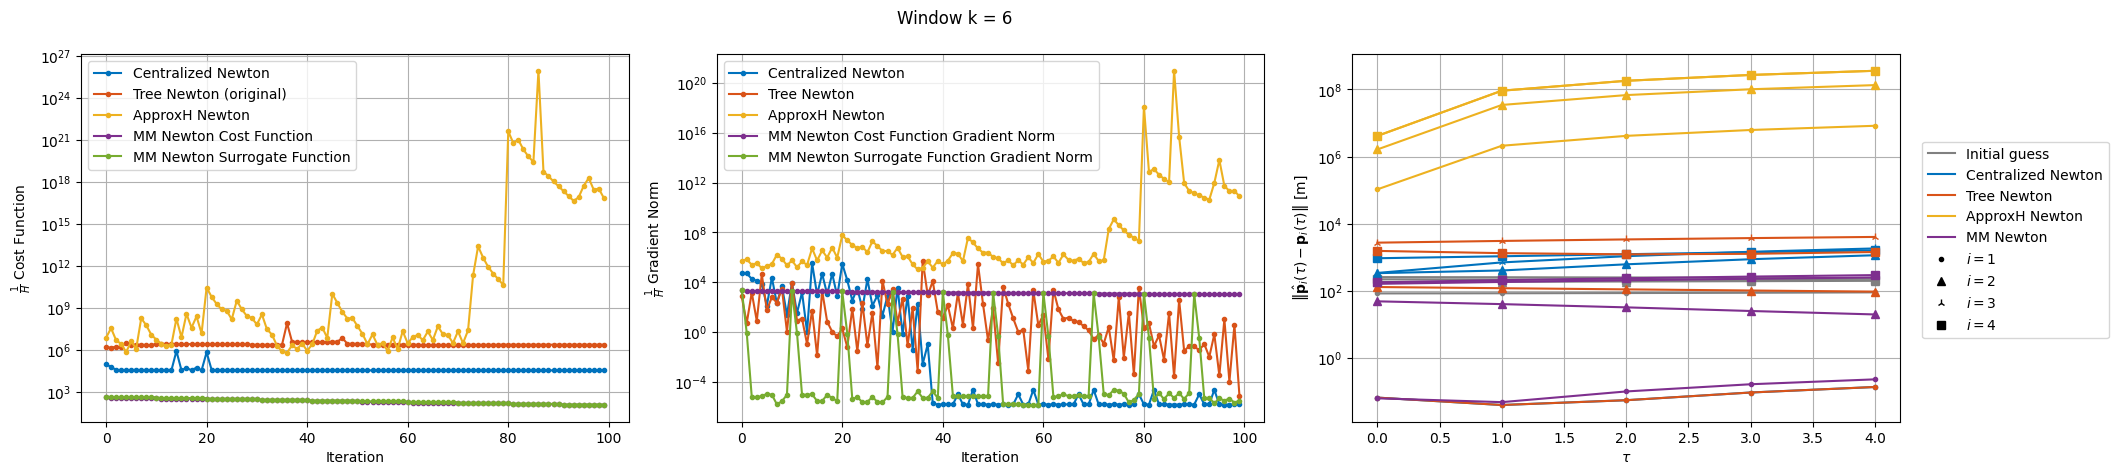


Windows:  50%|█████     | 3/6 [01:02<01:02, 20.70s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 2182999.3900009915
Gradient norm: 1073.856589659663
Global relative error: 3347.928227867403
Position relative errors: 0.03991157443554231 m, 120.01334757625891 m, 3070.663356740774 m, 1328.593008773948 m

Before applying the algorithm
Cost function: 1.28107428775179e+17
Gradient norm: 106236111526.65138
Global relative error: 133735574.29706939Before applying the algorithm
L_norm = 42245.11520355591
Grad_L_norm = 14775.32320778742


Position relative errors: 2096681.1955763462 m, 34393460.075321905 m, 91361435.57047275 m, 91358004.96995035 m

Iteration 1
Cost function: 2133780.539767093 (-2.25%)
Gradient norm: 411.92606739285617 (-61.64%)
Global relative error: 3364.71384968943 (0.50%)
Position relative errors: 0.07159581491154277 m, 350.67606715392685 m, 3065.4022209576547 m, 1342.2164846211583 m

Iteration 1
L_norm = 19089673.67480016
Grad_

/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=1.94786e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 15
Cost function: 2010035.7642041813 (-0.00%)
Gradient norm: 3.959941908917136e-06 (-20.57%)
Global relative error: 3415.435221105998 (0.00%)
Position relative errors: 0.07159580842201606 m, 232.3638280278297 m, 3085.115798415131 m, 1446.784441249866 m

Iteration 16
L_norm = 1097993789.411406
Grad_L_norm = 12825630.034558931

Iteration 16
Cost function: 2.70645394537393e+17 (-93.08%)
Gradient norm: 5.8624944518142264e+16 (-92.85%)
Global relative error: 9784881.754112093 (-64.77%)
Position relative errors: 323119.49530695874 m, 9609287.388891496 m, 1284612.9510570616 m, 1283669.8201039697 m



/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=4.58864e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 16
Cost function: 2010035.764165656 (-0.00%)
Gradient norm: 4.05862694827915e-06 (2.49%)
Global relative error: 3415.4352210761813 (-0.00%)
Position relative errors: 0.07159580842201606 m, 232.36382807177748 m, 3085.1157984137526 m, 1446.7844411753592 m

Iteration 17
L_norm = 2250671.894962734
Grad_L_norm = 360726.68360636005

Iteration 17
Cost function: 3.3680554118334668e+16 (-87.56%)
Gradient norm: 7439431721625610.0 (-87.31%)
Global relative error: 5827081.910960057 (-40.45%)
Position relative errors: 314934.47543911764 m, 825451.4858429062 m, 4070962.4000562173 m, 4073945.081168213 m

Iteration 17
Cost function: 2010035.764229754 (0.00%)
Gradient norm: 4.106365865517828e-06 (1.18%)
Global relative error: 3415.435221115257 (0.00%)
Position relative errors: 0.0715958083931373 m, 232.3638279872943 m, 3085.1157984277793 m, 1446.7844412512618 m

Iteration 18
L_norm = 7472489853.79825
Grad_L_norm = 33662294.81914702

Iteration 18
Cost function: 2242303389987230.5 (-93.34%)
Gra

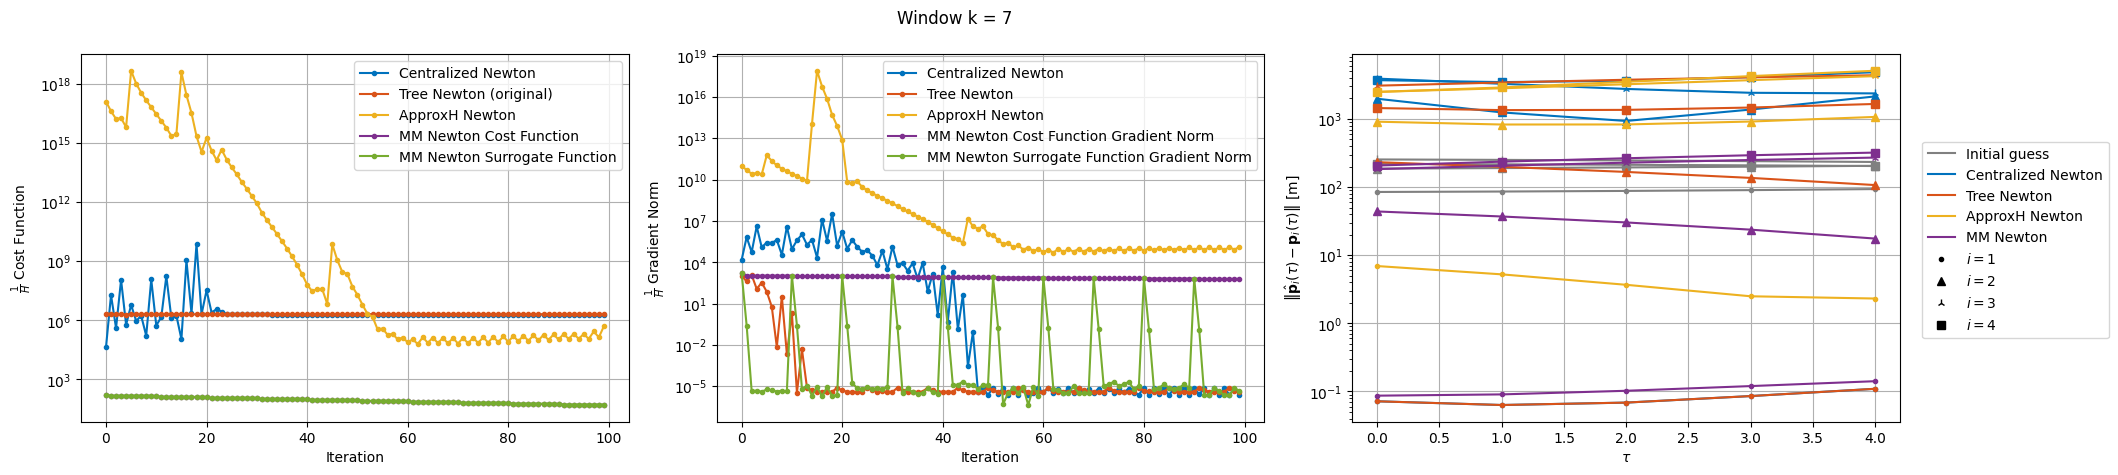


Windows:  67%|██████▋   | 4/6 [01:22<00:41, 20.75s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 1973708.8080474497
Gradient norm: 1277.4053057762212
Global relative error: 3692.414090813529
Position relative errors: 0.06315946852878179 m, 198.78767455830192 m, 3431.0182786464397 m, 1349.9784371920903 m

Before applying the algorithm
L_norm = 3085567.7331765704
Grad_L_norm = 120152.3180535214

Before applying the algorithm
Cost function: 641188.868599551
Gradient norm: 249773.79543786537
Global relative error: 4133.360776755921
Iteration 1
L_norm = 65303310.34121765
Grad_L_norm = 861230.1281605233
Position relative errors: 5.233248274673967 m, 829.5123352696405 m, 2823.468950228419 m, 2902.4550286924346 m
Iteration 1
Cost function: 1937309.920967206 (-1.84%)
Gradient norm: 18.901235837997152 (-98.52%)
Global relative error: 3688.258477575595 (-0.11%)


Position relative errors: 0.16601657767847236 m, 156.20847857408043 m, 3414.47191192100

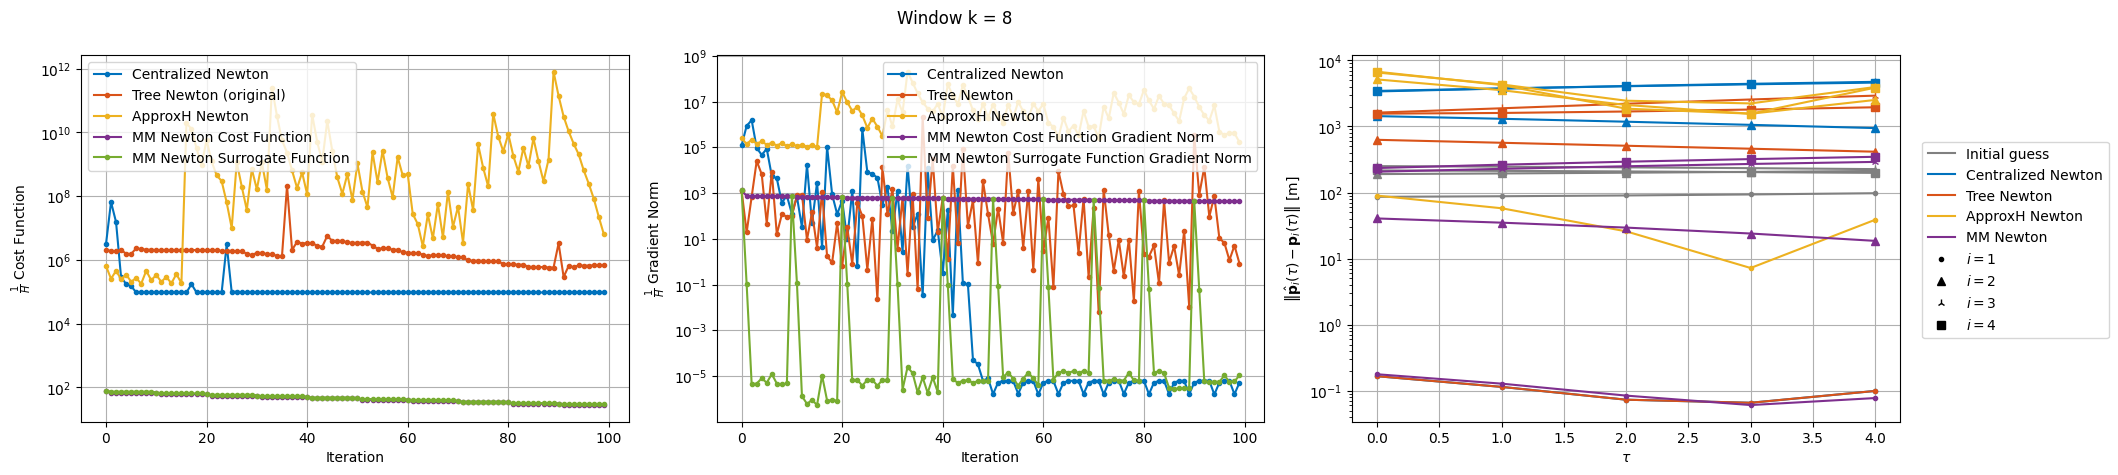


Windows:  83%|████████▎ | 5/6 [01:43<00:20, 20.79s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 4455407.8333632145
Gradient norm: 320098.6178570571
Global relative error: 7001.6360953943895
Position relative errors: 57.784951920170954 m, 3534.837503303658 m, 4323.714888140719 m, 4222.047869286733 m

Before applying the algorithm
L_norm = 86577.3333114195
Grad_L_norm = 1721.0429369789554

Before applying the algorithm
Cost function: 753542.8216517009
Gradient norm: 1259.8005848697796
Global relative error: 2534.896648167492
Position relative errors: 0.11438564424759844 m, 566.0226771330942 m, 1883.18696021008 m, 1599.6392830168934 m

Iteration 1
Cost function: 168335978.16724533 (3678.24%)
Gradient norm: 4312696.061550621 (1247.30%)
Global relative error: 12326.757853283852 (76.06%)
Position relative errors: 55.87218890668223 m, 2594.658329671434 m, 11783.019059822333 m, 2520.411308672878 m
Iteration 1
Cost function: 780266.872770651 (3.5

/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=7.65128e-27): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Position relative errors: 0.12614318064491742 m, 741.3367497688965 m, 2367.7587845220505 m, 1546.0454089823836 m

Iteration 46
L_norm = 86632.32956655565
Grad_L_norm = 1.5753612427979487e-05

Iteration 46
Cost function: 2.6173090503791305e+24 (-79.78%)
Gradient norm: 699683809721192.6 (-100.00%)
Global relative error: 403261238661.4443 (23050110.19%)
Iteration 47
Cost function: 451248.0981667152 (-0.00%)
Gradient norm: 8.71168158967779e-06 (42.03%)
Global relative error: 2923.381894772987 (0.00%)Position relative errors: 7628692480.109359 m, 2428084.523481332 m, 54810114382.29762 m, 399332549552.4087 m


Position relative errors: 0.12614318064491742 m, 741.3367497744681 m, 2367.758784520539 m, 1546.04540898648 m

Iteration 47
L_norm = 86632.32956655734
Grad_L_norm = 1.515982767470106e-05

Iteration 47
Cost function: 2.94352710361898e+23 (-88.75%)
Gradient norm: 220089343157455.72 (-68.54%)
Global relative error: 190603932523.81284 (-52.73%)
Position relative errors: 2616476264.972495 

/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=1.16425e-24): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 63
Cost function: 451248.09814528236 (-0.00%)
Gradient norm: 8.630806609202903e-06 (40.45%)
Global relative error: 2923.3818947500504 (0.00%)
Position relative errors: 0.12614318064491742 m, 741.3367497062179 m, 2367.758784523006 m, 1546.0454089720592 m

Iteration 63
L_norm = 86632.32956655583
Grad_L_norm = 1.5758101674118388e-05

Iteration 63
Cost function: 2.5639379992068783e+26 (408.67%)
Gradient norm: 2.1350624488217932e+25 (267.83%)
Global relative error: 239752619.82357073 (-36.43%)
Position relative errors: 5921860.364155072 m, 133369490.6274614 m, 133373541.62236853 m, 147869693.43019938 m



/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=7.56665e-25): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 64
Cost function: 451248.0981461564 (0.00%)
Gradient norm: 4.5450301500298325e-06 (-47.34%)
Global relative error: 2923.381894598914 (-0.00%)
Position relative errors: 0.12614318064491742 m, 741.336749726995 m, 2367.758784522463 m, 1546.0454086771492 m

Iteration 64
L_norm = 86632.32956655677
Grad_L_norm = 1.5218799904427615e-05

Iteration 64
Cost function: 1.9838028579903233e+25 (-92.26%)
Gradient norm: 1.6608374194957058e+24 (-92.22%)
Global relative error: 161355293.72972554 (-32.70%)
Position relative errors: 5962943.607899073 m, 94311705.12724529 m, 94313644.1153947 m, 90597994.16059425 m



/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=5.93181e-24): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 65
Cost function: 451248.09821683384 (0.00%)
Gradient norm: 8.625465689079446e-06 (89.78%)
Global relative error: 2923.3818947433033 (0.00%)
Position relative errors: 0.12614318064491742 m, 741.3367497993381 m, 2367.758784522155 m, 1546.0454089159532 m

Iteration 65
L_norm = 86632.32956655645
Grad_L_norm = 1.578563045315962e-05

Iteration 65
Cost function: 5.231828968037418e+18 (-100.00%)
Gradient norm: 4.2375066518964685e+17 (-100.00%)
Global relative error: 99524614.66644844 (-38.32%)
Position relative errors: 5893072.549391773 m, 53447099.963066384 m, 53451269.16725307 m, 64466160.753098175 m



/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=3.23613e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 66
Cost function: 451248.0981620482 (-0.00%)
Gradient norm: 6.149637640338327e-06 (-28.70%)
Global relative error: 2923.3818946817887 (-0.00%)
Position relative errors: 0.12614318064491742 m, 741.3367497516989 m, 2367.7587845222074 m, 1546.0454088223996 m

Iteration 66
L_norm = 86632.32956655785
Grad_L_norm = 1.5244940178776629e-05

Iteration 66
Cost function: 1454979624278607.2 (-99.97%)
Gradient norm: 31487540152.859432 (-100.00%)
Global relative error: 65383915.926418364 (-34.30%)
Position relative errors: 1184607.1187271664 m, 38632203.19080477 m, 38634489.98956018 m, 35891360.28059765 m

Iteration 67
Cost function: 451248.09818269237 (0.00%)
Gradient norm: 8.843289062028962e-06 (43.80%)
Global relative error: 2923.381894778085 (0.00%)
Position relative errors: 0.12614318064491742 m, 741.3367498008457 m, 2367.758784522463 m, 1546.0454089805264 m

Iteration 67
L_norm = 86632.32956655612
Grad_L_norm = 4.22275883920318e-06

Iteration 67
Cost function: 584652460325205.2 (-59.

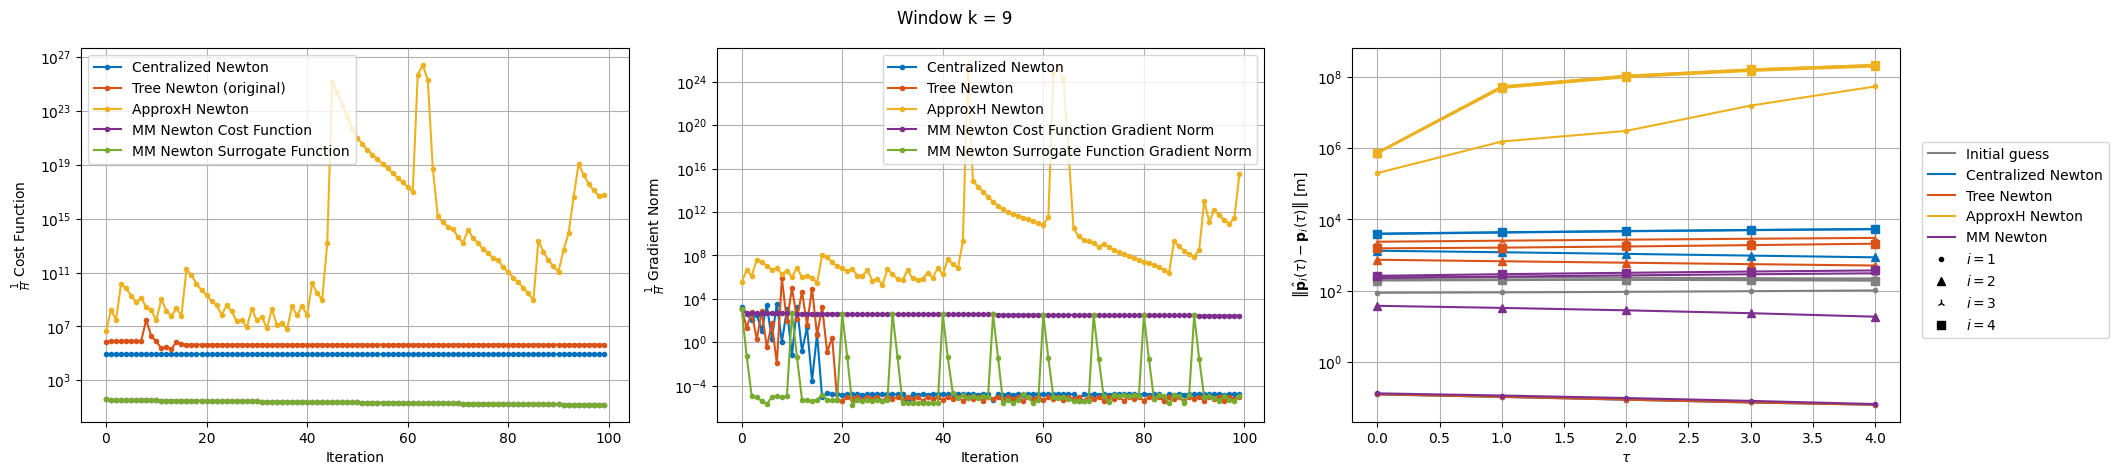


MC runs: 100%|██████████| 1/1 [02:04<00:00, 124.10s/it][A


In [205]:
if use_several_cpus and use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs AND CAUSAL
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = np.zeros((24, 1, K))  # Centralized Newton
    X_est_tree_newton_history = np.zeros((24, 1, K))  # Tree Newton
    X_est_approx_newton_history = np.zeros((24, 1, K))  # ApproxH Newton
    X_est_mm_history = np.zeros((24, 1, K))  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n - W + 1] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
    
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=3) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Propagate the estimated initial conditions until the end of the finite-horizon window
            if n == W - 1:
                X_est_unkkt_history[:, :, 0] = X_est_unkkt
                X_est_tree_newton_history[:, :, 0] = X_est_tree_newton
                X_est_approx_newton_history[:, :, 0] = X_est_approx_newton
                X_est_mm_history[:, :, 0] = X_est_mm
                for tau in range(W - 1):
                    X_est_unkkt_history[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, tau])
                    X_est_tree_newton_history[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, tau])
                    X_est_approx_newton_history[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, tau])
                    X_est_mm_history[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, tau])
            else:
                X_est_unkkt_history[:, :, n] = X_est_unkkt
                X_est_tree_newton_history[:, :, n] = X_est_tree_newton
                X_est_approx_newton_history[:, :, n] = X_est_approx_newton
                X_est_mm_history[:, :, n] = X_est_mm
                for tau in range(W - 1):
                    X_est_unkkt_history[:, :, n] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, n])
                    X_est_tree_newton_history[:, :, n] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, n])
                    X_est_approx_newton_history[:, :, n] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, n])
                    X_est_mm_history[:, :, n] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, n])
                
            # Plot results **in the main process**
            fig, axs = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8))
    
            # Cost function values
            axs[0].plot(cost_unkkt, '.-', label='Centralized Newton')
            axs[0].plot(cost_tree, '.-', label='Tree Newton (original)')
            axs[0].plot(cost_approx, '.-', label='ApproxH Newton')
            axs[0].plot(cost_mm, '.-', label='MM Newton Cost Function')
            axs[0].plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            axs[0].set_xlabel('Iteration')
            axs[0].set_ylabel(r'$\frac{1}{H}$ Cost Function')
            axs[0].set_yscale('log')
            axs[0].grid(True)
            axs[0].legend()
    
            # Gradient norm values
            axs[1].plot(grad_unkkt, '.-', label='Centralized Newton')
            axs[1].plot(grad_tree, '.-', label='Tree Newton')
            axs[1].plot(grad_approx, '.-', label='ApproxH Newton')
            axs[1].plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            axs[1].plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel(r'$\frac{1}{H}$ Gradient Norm')
            axs[1].set_yscale('log')
            axs[1].grid(True)
            axs[1].legend()

            # Initialize storage for current estimates
            X_est_unkkt_current = np.zeros((24, 1, W))
            X_est_tree_newton_current = np.zeros((24, 1, W))
            X_est_approx_newton_current = np.zeros((24, 1, W))
            X_est_mm_current = np.zeros((24, 1, W))
            
            # Simulate forward propagation over the window
            X_est_unkkt_current[:, :, 0] = X_est_unkkt
            X_est_tree_newton_current[:, :, 0] = X_est_tree_newton
            X_est_approx_newton_current[:, :, 0] = X_est_approx_newton
            X_est_mm_current[:, :, 0] = X_est_mm
            
            for tau in range(W - 1):
                X_est_unkkt_current[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_current[:, :, tau])
                X_est_tree_newton_current[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_current[:, :, tau])
                X_est_approx_newton_current[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_current[:, :, tau])
                X_est_mm_current[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_current[:, :, tau])
            
            # Compute position estimation errors
            dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current = position_estimation_error(X_est_unkkt_current, X_true[:, :, n - W + 1 : n + 1])
            dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current = position_estimation_error(X_est_tree_newton_current, X_true[:, :, n - W + 1 : n + 1])
            dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current = position_estimation_error(X_est_approx_newton_current, X_true[:, :, n - W + 1 : n + 1])
            dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current = position_estimation_error(X_est_mm_current, X_true[:, :, n - W + 1 : n + 1])
            
            # Define colors for algorithms
            algorithm_colors = {
                'Initial guess': 'grey',
                'Centralized Newton': 'C0',
                'Tree Newton': 'C1',
                'ApproxH Newton': 'C2',
                'MM Newton': 'C3'
            }
            
            # Define markers for different agents (i = 1, ..., 4)
            markers = ['.', '^', '2', 's', 'P']
            
            # Plot Initial Guess deviations (use the same color for all i)
            for i, dev_initial in enumerate([dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial]):
                axs[2].plot(dev_initial[n - W + 1 : n + 1], linestyle='-', color=algorithm_colors['Initial guess'], marker=markers[i])
            
            # Plot Centralized Newton deviations
            for i, dev_unkkt in enumerate([dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current]):
                axs[2].plot(dev_unkkt, linestyle='-', color=algorithm_colors['Centralized Newton'], marker=markers[i])
            
            # Plot Tree Newton deviations
            for i, dev_tree in enumerate([dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current]):
                axs[2].plot(dev_tree, linestyle='-', color=algorithm_colors['Tree Newton'], marker=markers[i])
            
            # Plot ApproxH Newton deviations
            for i, dev_approxh in enumerate([dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current]):
                axs[2].plot(dev_approxh, linestyle='-', color=algorithm_colors['ApproxH Newton'], marker=markers[i])
            
            # Plot MM Newton deviations
            for i, dev_mm in enumerate([dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current]):
                axs[2].plot(dev_mm, linestyle='-', color=algorithm_colors['MM Newton'], marker=markers[i])
            
            # Set axis labels and scale
            axs[2].set_xlabel(r'$\tau$')
            axs[2].set_ylabel(r'$\left\|\hat{\mathbf{p}}_i(\tau) - \mathbf{p}_i(\tau)\right\|$ [m]')
            axs[2].set_yscale('log')
            axs[2].grid(True)
            
            # Create legend (Colors for Algorithms, Markers for Agents)
            legend_elements = [
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Initial guess'], label='Initial guess'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Centralized Newton'], label='Centralized Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Tree Newton'], label='Tree Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['ApproxH Newton'], label='ApproxH Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['MM Newton'], label='MM Newton'),
                Line2D([0], [0], linestyle='', marker='.', color='black', label='$i = 1$'),
                Line2D([0], [0], linestyle='', marker='^', color='black', label='$i = 2$'),
                Line2D([0], [0], linestyle='', marker='2', color='black', label='$i = 3$'),
                Line2D([0], [0], linestyle='', marker='s', color='black', label='$i = 4$')
            ]
            fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
            fig.suptitle(f'Window k = {n}')
            plt.tight_layout() 
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

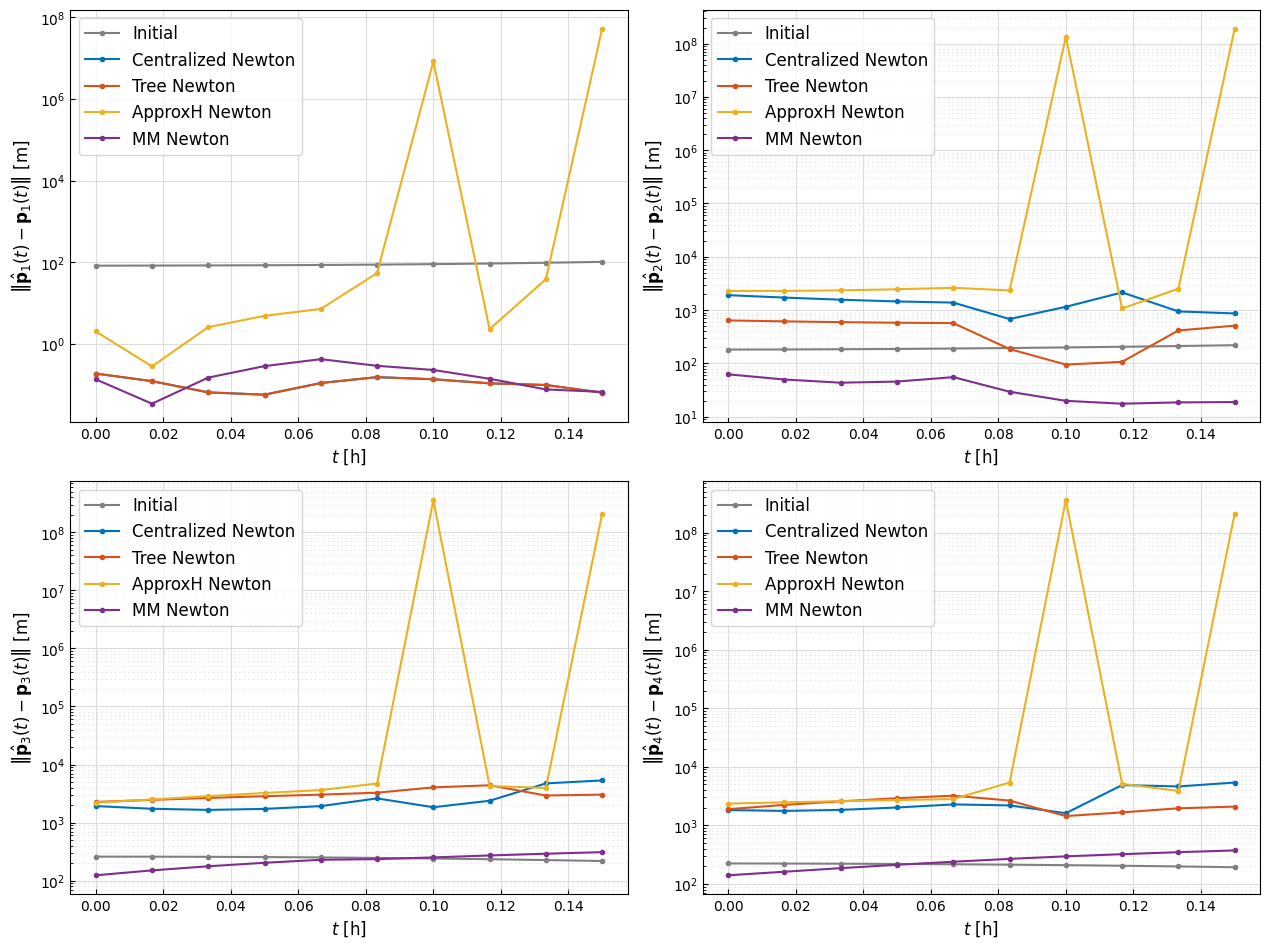

In [206]:
# Extract deviations for Chief and Deputies
dev_chief_unkkt, dev_deputy1_unkkt, dev_deputy2_unkkt, dev_deputy3_unkkt = position_estimation_error(X_est_unkkt_history, X_true)
dev_chief_tree, dev_deputy1_tree, dev_deputy2_tree, dev_deputy3_tree = position_estimation_error(X_est_tree_newton_history, X_true)
dev_chief_approx, dev_deputy1_approx, dev_deputy2_approx, dev_deputy3_approx = position_estimation_error(X_est_approx_newton_history, X_true)
dev_chief_mm, dev_deputy1_mm, dev_deputy2_mm, dev_deputy3_mm = position_estimation_error(X_est_mm_history, X_true)

# Time array
T = X_true.shape[2]

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", color='grey', label="Initial")
axs[0, 0].plot(time, dev_chief_unkkt, ".-", color='C0', label="Centralized Newton")
axs[0, 0].plot(time, dev_chief_tree, ".-", color='C1', label="Tree Newton")
axs[0, 0].plot(time, dev_chief_approx, ".-", color='C2', label="ApproxH Newton")
axs[0, 0].plot(time, dev_chief_mm, ".-", color='C3', label="MM Newton")
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_1(t) - \\mathbf{p}_1(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", color='grey', label="Initial")
axs[0, 1].plot(time, dev_deputy1_unkkt, ".-", color='C0', label="Centralized Newton")
axs[0, 1].plot(time, dev_deputy1_tree, ".-", color='C1', label="Tree Newton")
axs[0, 1].plot(time, dev_deputy1_approx, ".-", color='C2', label="ApproxH Newton")
axs[0, 1].plot(time, dev_deputy1_mm, ".-", color='C3', label="MM Newton")
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_2(t) - \\mathbf{p}_2(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", color='grey', label="Initial")
axs[1, 0].plot(time, dev_deputy2_unkkt, ".-", color='C0', label="Centralized Newton")
axs[1, 0].plot(time, dev_deputy2_tree, ".-", color='C1', label="Tree Newton")
axs[1, 0].plot(time, dev_deputy2_approx, ".-", color='C2', label="ApproxH Newton")
axs[1, 0].plot(time, dev_deputy2_mm, ".-", color='C3', label="MM Newton")
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_3(t) - \\mathbf{p}_3(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", color='grey', label="Initial")
axs[1, 1].plot(time, dev_deputy3_unkkt, ".-", color='C0', label="Centralized Newton")
axs[1, 1].plot(time, dev_deputy3_tree, ".-", color='C1', label="Tree Newton")
axs[1, 1].plot(time, dev_deputy3_approx, ".-", color='C2', label="ApproxH Newton")
axs[1, 1].plot(time, dev_deputy3_mm, ".-", color='C3', label="MM Newton")
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_4(t) - \\mathbf{p}_4(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()